## Machine learning, Baseline AI downscaler

August Posch --- March 2025 - Jan 2026

In this notebook:
- First, using reanalysis inputs and observed precip labels, train on 1975-1994 and validate on 1995-2014.
- Try various hyperparameterizations of the above and choose the one with the best MAE-APM score on the validation set.
- Visualize the implied APM and GEV curve from the best model predictions and from the observations.
- Then, using GCM inputs, do extra validation on 1995-2014 and also predict in the future periods 2031-2050 and 2041-2060, for various initial condition ensemble members.


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import genextreme as gev
import pickle
import matplotlib.pyplot as plt

## Specify the datasets

Reanalysis and observed datasets are specified here through this dictionary:

In [2]:
parameters = {
    'X_train_rean': '../data/ML_ready/boston_ERA5_1975_1994.npy',
    'y_train': '../data/ML_ready/gba_livneh_unsplit_1975_1994.npy',
    'X_val_rean': '../data/ML_ready/boston_ERA5_1995_2014.npy',
    'y_val': '../data/ML_ready/gba_livneh_unsplit_1995_2014.npy'
}

In [3]:
X_train_rean = np.load(parameters['X_train_rean'], allow_pickle=True)
y_train = np.load(parameters['y_train'], allow_pickle=True)
X_val_rean = np.load(parameters['X_val_rean'], allow_pickle=True)
y_val = np.load(parameters['y_val'], allow_pickle=True)

GCM datasets are specified through this dictionary:

In [4]:
longnamedict = {
    'GCM historical run 1995-2014, i001': np.load('../data/ML_ready/boston_CESM2-001_1995_2014.npy', allow_pickle=True),
    'GCM projection 2031-2050, i001': np.load('../data/ML_ready/boston_CESM2-001_2031_2050.npy', allow_pickle=True),
    'GCM projection 2041-2060, i001': np.load('../data/ML_ready/boston_CESM2-001_2041_2060.npy', allow_pickle=True),
    'GCM projection 2031-2050, i002': np.load('../data/ML_ready/boston_CESM2-002_2031_2050.npy', allow_pickle=True),
    'GCM projection 2041-2060, i002': np.load('../data/ML_ready/boston_CESM2-002_2041_2060.npy', allow_pickle=True),
    'GCM projection 2031-2050, i003': np.load('../data/ML_ready/boston_CESM2-003_2031_2050.npy', allow_pickle=True),
    'GCM projection 2041-2060, i003': np.load('../data/ML_ready/boston_CESM2-003_2041_2060.npy', allow_pickle=True),
}

## Train, select, and save a downscaler

Define all the hyperparameterizations we will search over.

In [5]:
hyperpzns_bank = {}
increment = 0
for n_estimators in [100, 300]:
    for max_features in [12, 9, 6]:
        for min_samples_split in [2, 4]:
            for bootstrap in [False, True]:

                increment += 1
                three_digit = str(increment).zfill(3)
                hyperpzns_bank['RF'+three_digit] = {
                    'n_estimators': n_estimators,
                    'max_features': max_features,
                    'bootstrap': bootstrap,
                    'min_samples_split': min_samples_split,
                    'random_state': 19
                }

Set up a dictionary of untrained models (scikit-learn estimator objects).

In [6]:
untrained_models = {}
for name, spec in hyperpzns_bank.items():
    untrained_models[name] = RandomForestRegressor(**spec) # these are sklearn model objects (estimators)

Define a funciton `fit_predict_rean()`, which trains/fits a model based on reanalysis data, prints some validation scores, and returns the trained model and the MAE-APM score. (Note: If you hold constant the random seed, the hyperparameterization, and the training dataset, then you always end up with the same model parameters a.k.a. model specification.)

In [7]:
def fit_predict_rean(model, X_train_rean, y_train, X_val_rean, y_val):
    
    print('> Fitting the model on the training set')
    model.fit(X_train_rean, y_train)
    print('> Predicting on the validation set')
    pred = model.predict(X_val_rean)
    print('> Recording performance metrics')
    
    # Mean Absolute Error of all days 1995-2014
    error =  pred - y_val
    mae = np.mean(np.abs(error))
    print('--> Mean Absolute Error:', np.round(mae,2), 'mm')
    
    # Mean Absolute Error of Annual Precipitation Maxima 1995-2014
    pred_apm = []
    y_val_apm = []
    dpy = [365,366,365,365]*5 # days per year 1995 to 2014
    for year in range(20):
        idx_yearstart = sum(dpy[:year])
        idx_nextyearstart = sum(dpy[:year+1])
        pred_maxthisyear = max(pred[idx_yearstart:idx_nextyearstart])
        y_val_maxthisyear = max(y_val[idx_yearstart:idx_nextyearstart])
        pred_apm.append(pred_maxthisyear)
        y_val_apm.append(y_val_maxthisyear)

    pred_apm = np.array(pred_apm)
    y_val_apm = np.array(y_val_apm)
    
    error_apm =  pred_apm - y_val_apm
    mae_apm = np.mean(np.abs(error_apm))
    print('--> MAE of Annual Precip Max:', np.round(mae_apm,2), 'mm')
    
    # GEV curves and implied flood levels
    shape, loc, scale = gev.fit(y_val_apm)
    print('--> Return levels in millimeters, GEV of observations 1995-2014:')
    one_pct_level_obs, four_pct_level_obs = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', np.round(one_pct_level_obs,2))
    print('----> 1/25 year level:', np.round(four_pct_level_obs,2))
    
    shape, loc, scale = gev.fit(pred_apm)
    print('--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:')
    one_pct_level_pred, four_pct_level_pred = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', np.round(one_pct_level_pred,2))
    print('----> 1/25 year level:', np.round(four_pct_level_pred,2))

    return model, mae_apm

Train with all the different hyperparameterizations; record trained models and their scores. (This took a couple hours on August's laptop.)

In [8]:
trained_models = {}
scores = {}
for name, untrained_model in untrained_models.items():
    # (could add a check here to only train if it hasn't been trained before)
    print('Model Name:', name)
    trained_model, score = fit_predict_rean(untrained_model, X_train_rean, y_train, X_val_rean, y_val)
    
    trained_models[name] = trained_model
    scores[name] = score

Model Name: RF001
> Fitting the model on the training set
> Predicting on the validation set
> Recording performance metrics
--> Mean Absolute Error: 3.82 mm
--> MAE of Annual Precip Max: 20.46 mm
--> Return levels in millimeters, GEV of observations 1995-2014:
----> 1/100 year level: 111.59
----> 1/25 year level: 102.77
--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:
----> 1/100 year level: 75.32
----> 1/25 year level: 74.77
Model Name: RF002
> Fitting the model on the training set
> Predicting on the validation set
> Recording performance metrics
--> Mean Absolute Error: 3.06 mm
--> MAE of Annual Precip Max: 33.69 mm
--> Return levels in millimeters, GEV of observations 1995-2014:
----> 1/100 year level: 111.59
----> 1/25 year level: 102.77
--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:
----> 1/100 year level: 55.58
----> 1/25 year level: 50.22
Model Name: RF003
> Fitting the model on the training set
> Predicting o

Identify best model and save it.

In [9]:
# "Which model name had the highest score?"
name_of_best = min(scores, key=scores.get)
print(f'The best model was {name_of_best}, achieving an MAE-APM of {scores[name_of_best]} mm')

print('This model used the following hyperparameterizations:\n', hyperpzns_bank[name_of_best])

# Save the trained model
path = '../trained_models/best_model.pkl'
pickle.dump(trained_models[name_of_best], open(path, 'wb'), protocol=5) 
print('Trained model saved here:', path)

# note about loading later - code looks like below
# model = pickle.load(open(filename, 'rb'))

The best model was RF001, achieving an MAE-APM of 20.463336002349855 mm
This model used the following hyperparameterizations:
 {'n_estimators': 100, 'max_features': 12, 'bootstrap': False, 'min_samples_split': 2, 'random_state': 19}
Trained model saved here: ../trained_models/best_model.pkl


In [10]:
def visualize_performance_rean(model, X_val_rean, y_val):
    pred = model.predict(X_val_rean)
    print('> Performance of the model with visuals.')
    
    # Mean Absolute Error of all days 1995-2014
    error =  pred - y_val
    mae = np.mean(np.abs(error))
    print('--> Mean Absolute Error:', np.round(mae,2), 'mm')
    
    # Mean Absolute Error of Annual Precipitation Maxima 1995-2014
    pred_apm = []
    y_val_apm = []
    dpy = [365,366,365,365]*5 # days per year 1995 to 2014
    for year in range(20):
        idx_yearstart = sum(dpy[:year])
        idx_nextyearstart = sum(dpy[:year+1])
        pred_maxthisyear = max(pred[idx_yearstart:idx_nextyearstart])
        y_val_maxthisyear = max(y_val[idx_yearstart:idx_nextyearstart])
        pred_apm.append(pred_maxthisyear)
        y_val_apm.append(y_val_maxthisyear)

    pred_apm = np.array(pred_apm)
    y_val_apm = np.array(y_val_apm)

    plt.bar(np.arange(1995,2015), pred_apm, width=-0.3, align='edge', color='orange', label='Predicted by model')
    plt.bar(np.arange(1995,2015), y_val_apm, width=0.3, align='edge', color='green', label='Observed')
    plt.xticks(ticks=np.arange(1995,2015), rotation=90)
    plt.ylabel('Annual Precipitation Max (mm)')
    plt.xlabel('Year')
    plt.title('Predicted and observed Annual Precipitation Max')
    plt.legend()
    plt.savefig('../figures/APM_pred_obs.png')
    plt.show()

    error_apm =  pred_apm - y_val_apm
    mae_apm = np.mean(np.abs(error_apm))
    print('--> MAE of Annual Precip Max:', np.round(mae_apm,2), 'mm')
    
    # GEV curves and implied flood levels
    
    shape, loc, scale = gev.fit(y_val_apm)
    print('--> Return levels in millimeters, GEV of observations 1995-2014:')
    one_pct_level_obs, four_pct_level_obs = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', np.round(one_pct_level_obs,2))
    print('----> 1/25 year level:', np.round(four_pct_level_obs,2))
    # Plot that curve
    pp = np.linspace(1/100, 0.85, 500) 
    xx = 1/pp
    yy = gev.isf(pp, shape, loc, scale)
    plt.plot(xx, yy, color='green', label='GEV of Observations')
    
    shape, loc, scale = gev.fit(pred_apm)
    print('--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:')
    one_pct_level_pred, four_pct_level_pred = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', np.round(one_pct_level_pred,2))
    print('----> 1/25 year level:', np.round(four_pct_level_pred,2))
    # Plot that curve
    pp = np.linspace(1/100, 0.85, 500) 
    xx = 1/pp
    yy = gev.isf(pp, shape, loc, scale)
    plt.plot(xx, yy, color='orange', label='GEV of ML Prediction')
    plt.ylabel('Extreme precipitation level (mm)')
    plt.xlabel('Return period (years)')
    plt.title(f'GEV intensity-frequency curves from predicted and observed')
    plt.legend()
    plt.savefig('../figures/GEV_pred_obs.png')
    plt.show()

> Performance of the model with visuals.
--> Mean Absolute Error: 3.82 mm


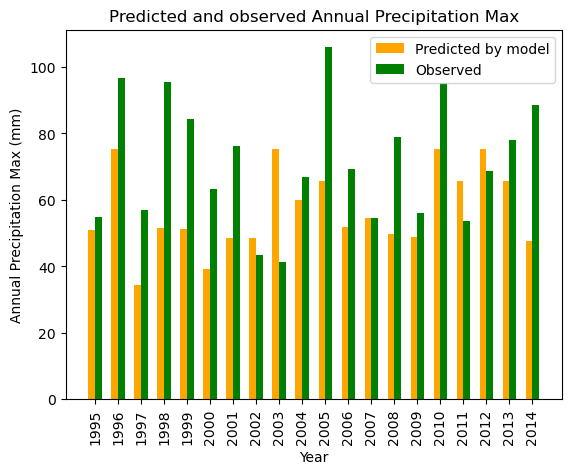

--> MAE of Annual Precip Max: 20.46 mm
--> Return levels in millimeters, GEV of observations 1995-2014:
----> 1/100 year level: 111.59
----> 1/25 year level: 102.77
--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:
----> 1/100 year level: 75.32
----> 1/25 year level: 74.77


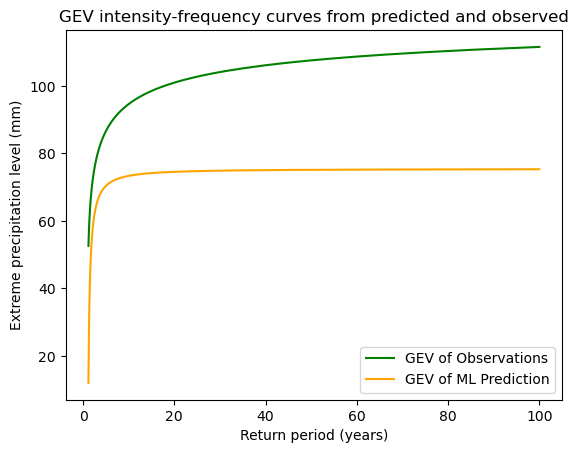

In [11]:
visualize_performance_rean(trained_models[name_of_best], X_val_rean, y_val)

## Make predictions from climate model data

In [12]:
model = pickle.load(open('../trained_models/best_model.pkl', 'rb'))

In [13]:
model

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",12
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples

In [14]:
# This one makes plots for any gcm 20-year dataset
def visualize_performance_gcm(model, gcm_dataset, dataset_name):

    # GCM VAL SET
    print(f'> Predicting on the {dataset_name} dataset')
    gcm_val_pred = model.predict(gcm_dataset)
    print('> Recording performance metrics')

    # Calculate Annual Precipitation Maxima
    gcm_val_pred_apm = []
    dpy = [365]*20 # model days per year - always 365
    for year in range(20):
        idx_yearstart = sum(dpy[:year])
        idx_nextyearstart = sum(dpy[:year+1])
        gcm_val_pred_maxthisyear = max(gcm_val_pred[idx_yearstart:idx_nextyearstart])
        gcm_val_pred_apm.append(gcm_val_pred_maxthisyear)

    print('--> APM predictions:', [np.round(i) for i in gcm_val_pred_apm])

    # GEV curves and implied flood levels
    shape, loc, scale = gev.fit(gcm_val_pred_apm)
    print(f'--> Return levels in millimeters, GEV of ML prediction from {dataset_name}:')
    one_pct_level_gcm_val_pred, four_pct_level_gcm_val_pred = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', one_pct_level_gcm_val_pred)
    print('----> 1/25 year level:', four_pct_level_gcm_val_pred)

    # Plot that curve
    pp = np.linspace(1/100, 0.85, 500) 
    xx = 1/pp
    yy = gev.isf(pp, shape, loc, scale)
    plt.plot(xx, yy, color='orange', label='GEV of ML Prediction')
    plt.ylabel('Extreme precipitation level (mm)')
    plt.xlabel('Return period (years)')
    plt.title(f'GEV intensity-frequency curves from {dataset_name}')
    plt.legend()
    dn = dataset_name.replace(',','')
    plt.savefig(f'../figures/GEV {dn}.png')
    plt.show()

> Predicting on the GCM historical run 1995-2014, i001 dataset
> Recording performance metrics
--> APM predictions: [np.float64(50.0), np.float64(54.0), np.float64(71.0), np.float64(58.0), np.float64(44.0), np.float64(50.0), np.float64(60.0), np.float64(36.0), np.float64(55.0), np.float64(46.0), np.float64(50.0), np.float64(64.0), np.float64(49.0), np.float64(53.0), np.float64(64.0), np.float64(59.0), np.float64(61.0), np.float64(46.0), np.float64(55.0), np.float64(71.0)]
--> Return levels in millimeters, GEV of ML prediction from GCM historical run 1995-2014, i001:
----> 1/100 year level: 73.92884217371255
----> 1/25 year level: 69.95063056335366


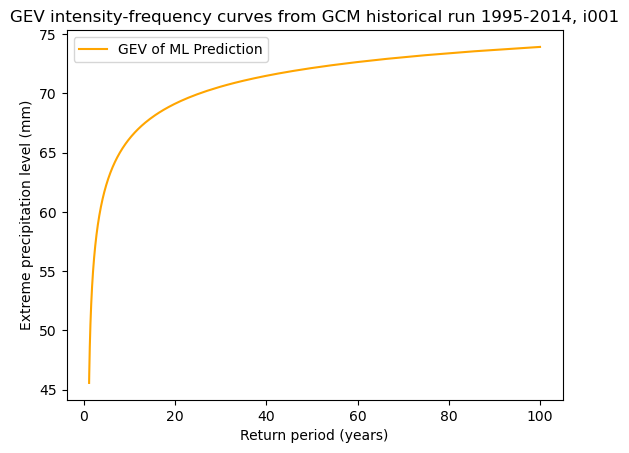

> Predicting on the GCM projection 2031-2050, i001 dataset
> Recording performance metrics
--> APM predictions: [np.float64(66.0), np.float64(56.0), np.float64(59.0), np.float64(71.0), np.float64(62.0), np.float64(58.0), np.float64(54.0), np.float64(66.0), np.float64(61.0), np.float64(49.0), np.float64(66.0), np.float64(57.0), np.float64(61.0), np.float64(61.0), np.float64(52.0), np.float64(58.0), np.float64(64.0), np.float64(49.0), np.float64(57.0), np.float64(60.0)]
--> Return levels in millimeters, GEV of ML prediction from GCM projection 2031-2050, i001:
----> 1/100 year level: 71.36465577657168
----> 1/25 year level: 71.36342553218378


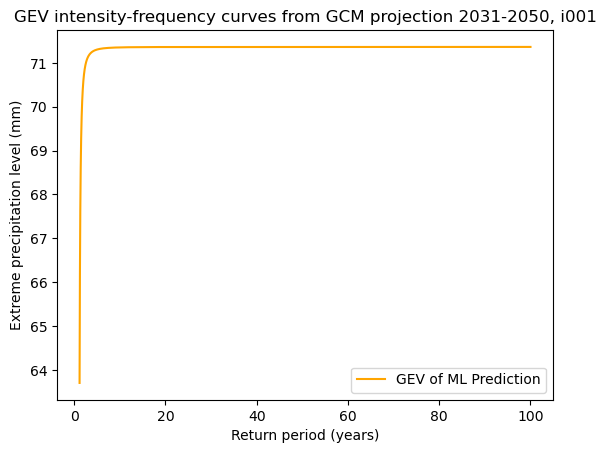

> Predicting on the GCM projection 2041-2060, i001 dataset
> Recording performance metrics
--> APM predictions: [np.float64(66.0), np.float64(57.0), np.float64(61.0), np.float64(61.0), np.float64(52.0), np.float64(58.0), np.float64(64.0), np.float64(49.0), np.float64(57.0), np.float64(60.0), np.float64(66.0), np.float64(52.0), np.float64(61.0), np.float64(46.0), np.float64(57.0), np.float64(61.0), np.float64(64.0), np.float64(56.0), np.float64(61.0), np.float64(66.0)]
--> Return levels in millimeters, GEV of ML prediction from GCM projection 2041-2060, i001:
----> 1/100 year level: 65.71731436382976
----> 1/25 year level: 65.55576580043682


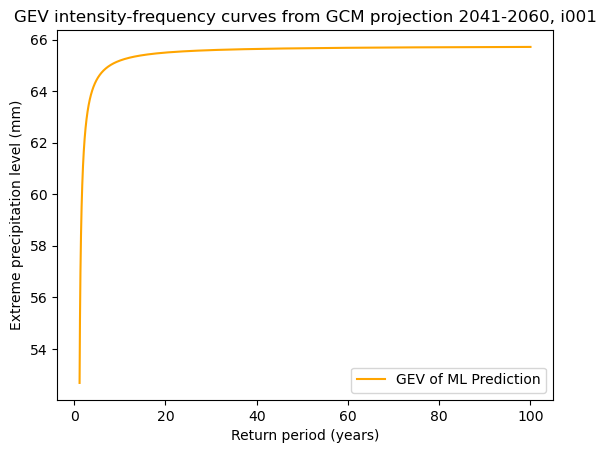

> Predicting on the GCM projection 2031-2050, i002 dataset
> Recording performance metrics
--> APM predictions: [np.float64(50.0), np.float64(44.0), np.float64(52.0), np.float64(60.0), np.float64(63.0), np.float64(52.0), np.float64(61.0), np.float64(58.0), np.float64(48.0), np.float64(58.0), np.float64(58.0), np.float64(61.0), np.float64(66.0), np.float64(60.0), np.float64(60.0), np.float64(57.0), np.float64(44.0), np.float64(63.0), np.float64(58.0), np.float64(33.0)]
--> Return levels in millimeters, GEV of ML prediction from GCM projection 2031-2050, i002:
----> 1/100 year level: 65.6747142767201
----> 1/25 year level: 64.89012403882516


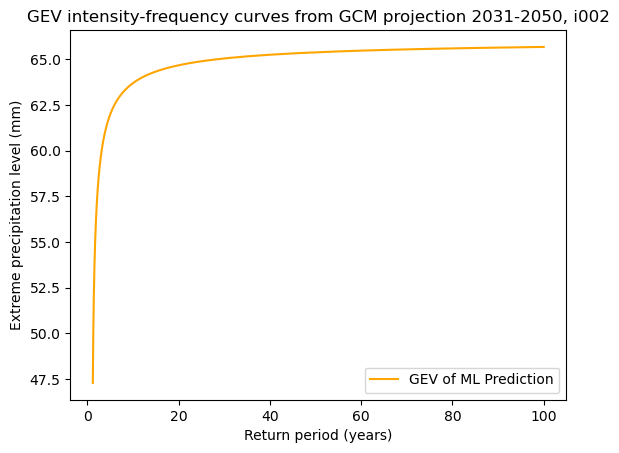

> Predicting on the GCM projection 2041-2060, i002 dataset
> Recording performance metrics
--> APM predictions: [np.float64(58.0), np.float64(61.0), np.float64(66.0), np.float64(60.0), np.float64(60.0), np.float64(57.0), np.float64(44.0), np.float64(63.0), np.float64(58.0), np.float64(33.0), np.float64(52.0), np.float64(55.0), np.float64(47.0), np.float64(64.0), np.float64(44.0), np.float64(66.0), np.float64(70.0), np.float64(58.0), np.float64(63.0), np.float64(49.0)]
--> Return levels in millimeters, GEV of ML prediction from GCM projection 2041-2060, i002:
----> 1/100 year level: 69.64512738830491
----> 1/25 year level: 68.31877281693298


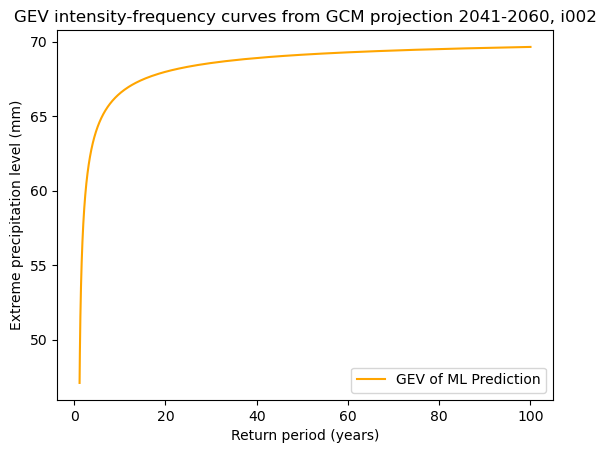

> Predicting on the GCM projection 2031-2050, i003 dataset
> Recording performance metrics
--> APM predictions: [np.float64(54.0), np.float64(66.0), np.float64(48.0), np.float64(43.0), np.float64(61.0), np.float64(57.0), np.float64(48.0), np.float64(66.0), np.float64(61.0), np.float64(60.0), np.float64(63.0), np.float64(52.0), np.float64(42.0), np.float64(52.0), np.float64(71.0), np.float64(59.0), np.float64(58.0), np.float64(54.0), np.float64(61.0), np.float64(60.0)]
--> Return levels in millimeters, GEV of ML prediction from GCM projection 2031-2050, i003:
----> 1/100 year level: 70.80268674090946
----> 1/25 year level: 68.5153410755361


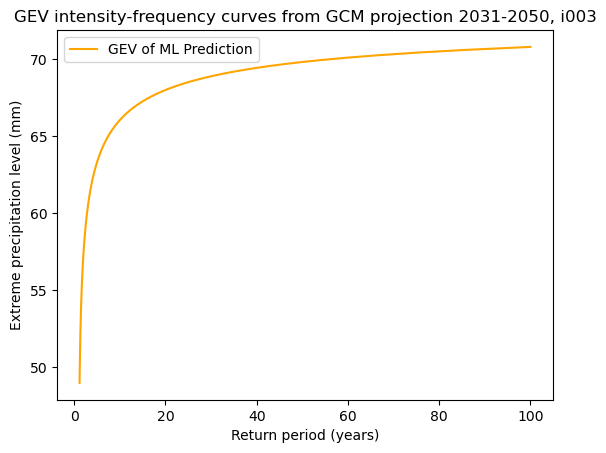

> Predicting on the GCM projection 2041-2060, i003 dataset
> Recording performance metrics
--> APM predictions: [np.float64(63.0), np.float64(52.0), np.float64(42.0), np.float64(52.0), np.float64(71.0), np.float64(59.0), np.float64(58.0), np.float64(54.0), np.float64(61.0), np.float64(60.0), np.float64(61.0), np.float64(72.0), np.float64(63.0), np.float64(49.0), np.float64(55.0), np.float64(61.0), np.float64(60.0), np.float64(50.0), np.float64(51.0), np.float64(75.0)]
--> Return levels in millimeters, GEV of ML prediction from GCM projection 2041-2060, i003:
----> 1/100 year level: 77.34389209718992
----> 1/25 year level: 72.88189210919343


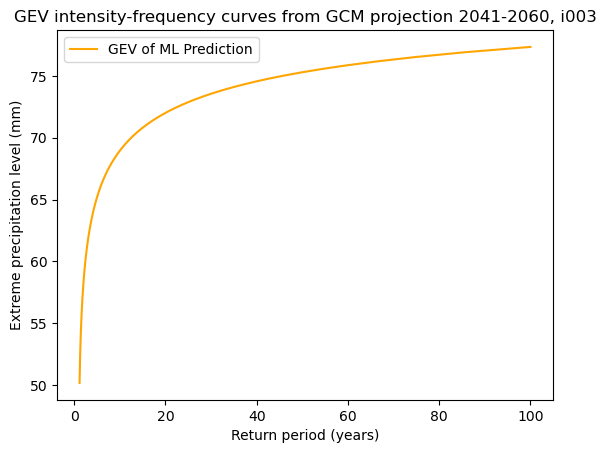

In [15]:
# cycle through dictionary and get readouts
for dataset_name, dataset in longnamedict.items():
    visualize_performance_gcm(model, dataset, dataset_name)